In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define paths
train_dir = 'C:\\Users\\KIIT\\Downloads\\archive (1)\\chest_xray\\train'
val_dir = 'C:\\Users\\KIIT\\Downloads\\archive (1)\\chest_xray\\val'
test_dir = 'C:\\Users\\KIIT\\Downloads\\archive (1)\\chest_xray\\test'


# Data preparation using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 224x224 for ResNet
    batch_size=32,
    class_mode='categorical'  # Multi-class classification (PNEUMONIA or NORMAL)
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense


# Define a single ResNet convolutional block
def convolutional_block(x, filters, stride):
    """
    A single ResNet convolutional block with residual connection
    Args:
    - x: Input tensor
    - filters: Number of filters for this block
    - stride: Stride for convolution

    Returns:
    - Output tensor
    """
    # Shortcut path
    shortcut = x
    if stride != 1 or x.shape[-1] != filters:  # Match the dimensions if needed
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Main path
    x = Conv2D(filters, (3, 3), strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)

    # Residual connection
    x = Add()([shortcut, x])
    x = ReLU()(x)
    
    return x


# ResNet model architecture
def build_resnet(input_shape, num_classes):
    """
    Builds a ResNet-18 architecture
    Args:
    - input_shape: Shape of input images
    - num_classes: Number of classes to predict
    Returns:
    - A compiled ResNet model
    """
    inputs = Input(shape=input_shape)

    # Initial convolution and pooling
    x = Conv2D(64, (7, 7), strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding="same")(x)

    # Define ResNet blocks
    num_blocks = [2, 2, 2, 2]  # ResNet-18's block structure
    filters = [64, 128, 256, 512]  # Filter size for each stage

    for i in range(len(num_blocks)):
        for j in range(num_blocks[i]):
            # Apply blocks with the specified number of filters and strides
            stride = 2 if j == 0 and i != 0 else 1  # Downsampling at block starts
            x = convolutional_block(x, filters[i], stride)

    # Global average pooling
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


# Input shape and number of classes
input_shape = (224, 224, 3)  # Resize images to 224x224
num_classes = 2  # PNEUMONIA and NORMAL

# Build ResNet model
model = build_resnet(input_shape, num_classes)

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]  

 Total params: 11,191,938 (42.69 MB)

 Trainable params: 11,182,338 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [5]:
# Paths to dataset directories
dataset_path_train = "C:/Users/KIIT/Downloads/archive (1)/chest_xray/train"
dataset_path_val = "C:/Users/KIIT/Downloads/archive (1)/chest_xray/val"

# Load training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path_train,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path_val,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

# Normalize the pixel values (0-255 to 0-1)
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Optimize dataset performance by prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [7]:
# Train the model
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    steps_per_epoch=len(train_ds),
    validation_steps=len(val_ds),
    verbose=1
)

# Print training history
print(history.history)


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 676s 4s/step - accuracy: 0.8514 - loss: 0.5192 - val_accuracy: 0.5000 - val_loss: 6.4274
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 571s 4s/step - accuracy: 0.9508 - loss: 0.1326 - val_accuracy: 0.3750 - val_loss: 1.5280
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 568s 3s/step - accuracy: 0.9619 - loss: 0.1065 - val_accuracy: 0.5000 - val_loss: 11.6410
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 574s 4s/step - accuracy: 0.9690 - loss: 0.0832 - val_accuracy: 0.5000 - val_loss: 10.4786
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 570s 3s/step - accuracy: 0.9778 - loss: 0.0672 - val_accuracy: 0.4375 - val_loss: 1.1863
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - accuracy: 0.9821 - loss: 0.0510 - val_accuracy: 0.5000 - val_loss: 2.4576
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step - accuracy: 0.9859 - loss: 0.0456 - val_accuracy: 0.5000 - val_loss: 4.4085
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 530s 3s/step - accuracy: 0.9822 - loss: 0.0507 - val_ac

Found 624 files belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 940ms/step - accuracy: 0.7365 - loss: 2.6562
Test Accuracy: 0.7596
Test Loss: 2.6326


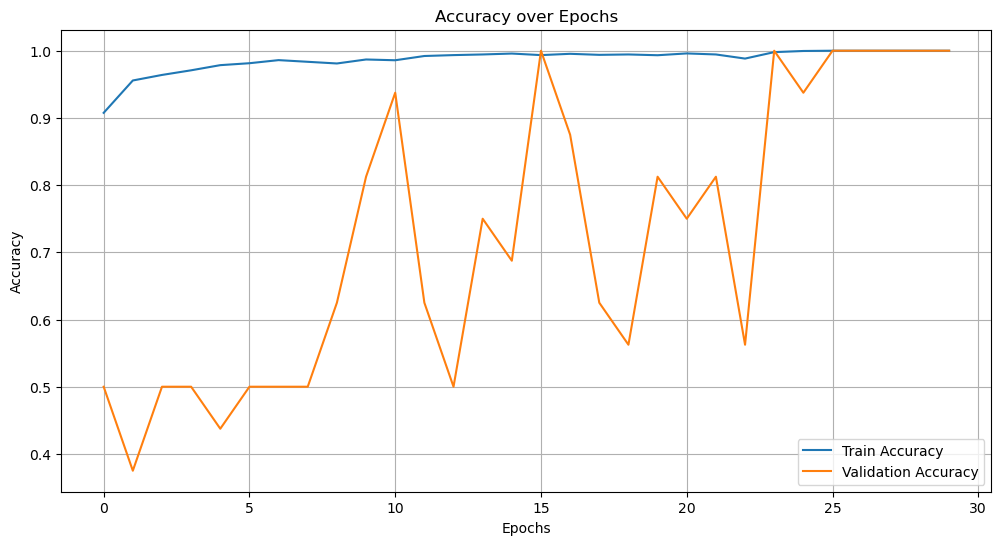

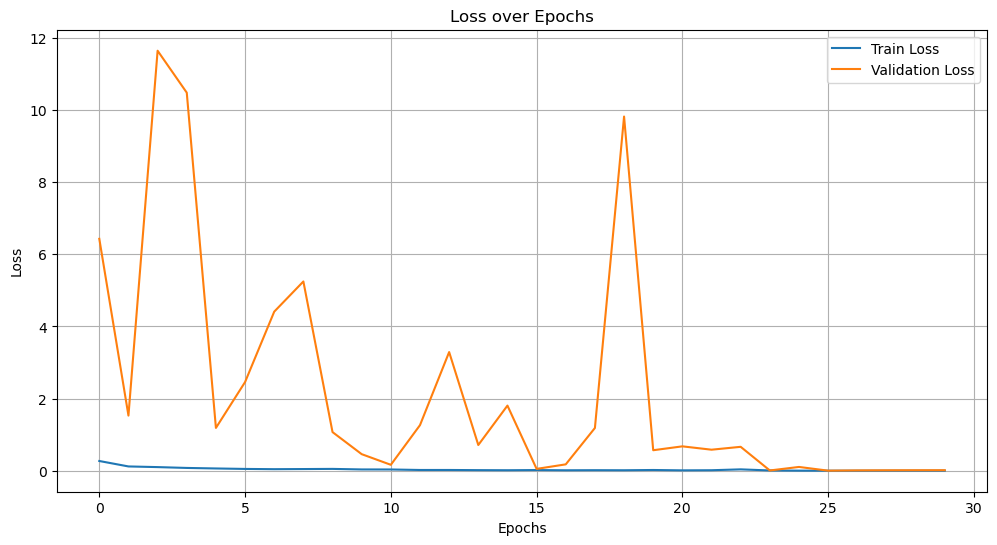

In [9]:
import matplotlib.pyplot as plt

# Paths to the test dataset
dataset_path_test = "C:/Users/KIIT/Downloads/archive (1)/chest_xray/test"

# Load the test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path_test,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"  # Use categorical encoding
)

# Normalize the test dataset
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Found 624 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.36      0.53       234
   PNEUMONIA       0.72      1.00      0.84       3

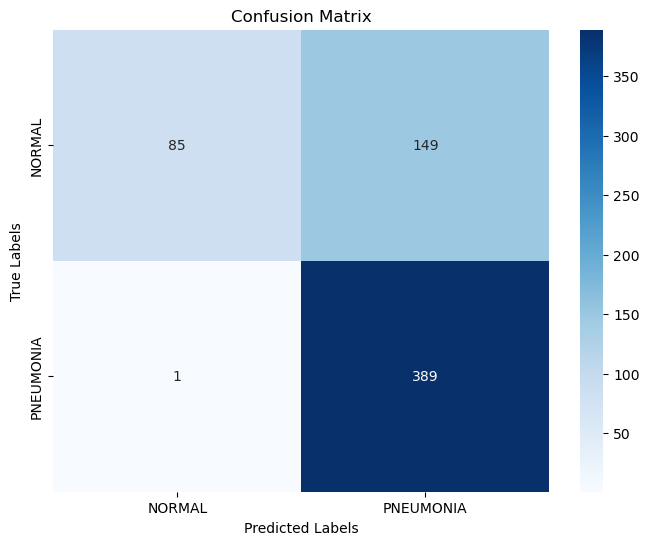

In [17]:
# Extract class names from the original dataset before mapping
original_test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path_test,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)
class_names = original_test_ds.class_names

# Proceed with the normalized test dataset for predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)  # Predict on batch
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted classes
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # True classes

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [19]:
# Path to the training dataset
dataset_path_train = "C:/Users/KIIT/Downloads/archive (1)/chest_xray/train"

# Path to the validation dataset
dataset_path_val = "C:/Users/KIIT/Downloads/archive (1)/chest_xray/val"

# Load the train and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path_train,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path_val,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [21]:
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [23]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [25]:
class_weights = {0: 1.0, 1: 2.0}  # Adjust weights depending on class imbalance
history = model.fit(train_ds, epochs=5, validation_data=val_ds, class_weight=class_weights)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - accuracy: 0.9636 - loss: 0.1529 - val_accuracy: 0.5000 - val_loss: 4.6743
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.9860 - loss: 0.0470 - val_accuracy: 0.6875 - val_loss: 0.7696
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.9961 - loss: 0.0178 - val_accuracy: 0.8125 - val_loss: 0.7004
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.9981 - loss: 0.0073 - val_accuracy: 0.8750 - val_loss: 0.6845
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - accuracy: 0.9965 - loss: 0.0128 - val_accuracy: 0.6875 - val_loss: 1.6265


In [27]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 844ms/step - accuracy: 0.6679 - loss: 3.0771
Test Accuracy: 0.6859
Test Loss: 2.7946


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.17      0.28       234
   PNEUMONIA       0.67      1.00      0.80       390

    accuracy                           0.69       624
   macro avg       0.82

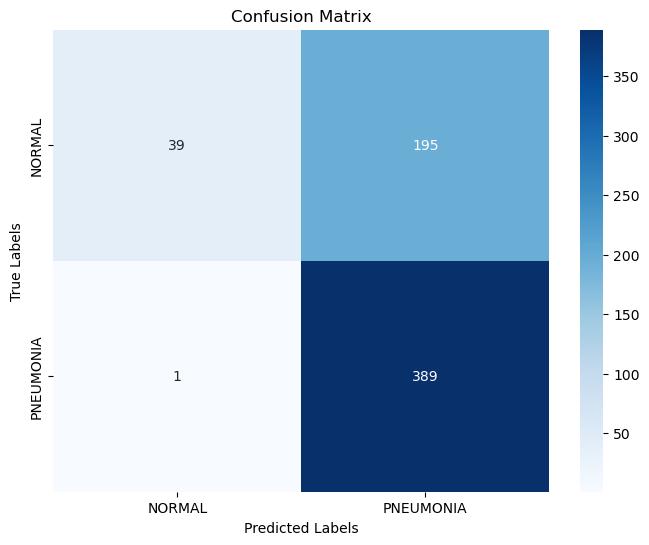

In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Collect predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate classification report
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

# Generate confusion matrix visualization
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


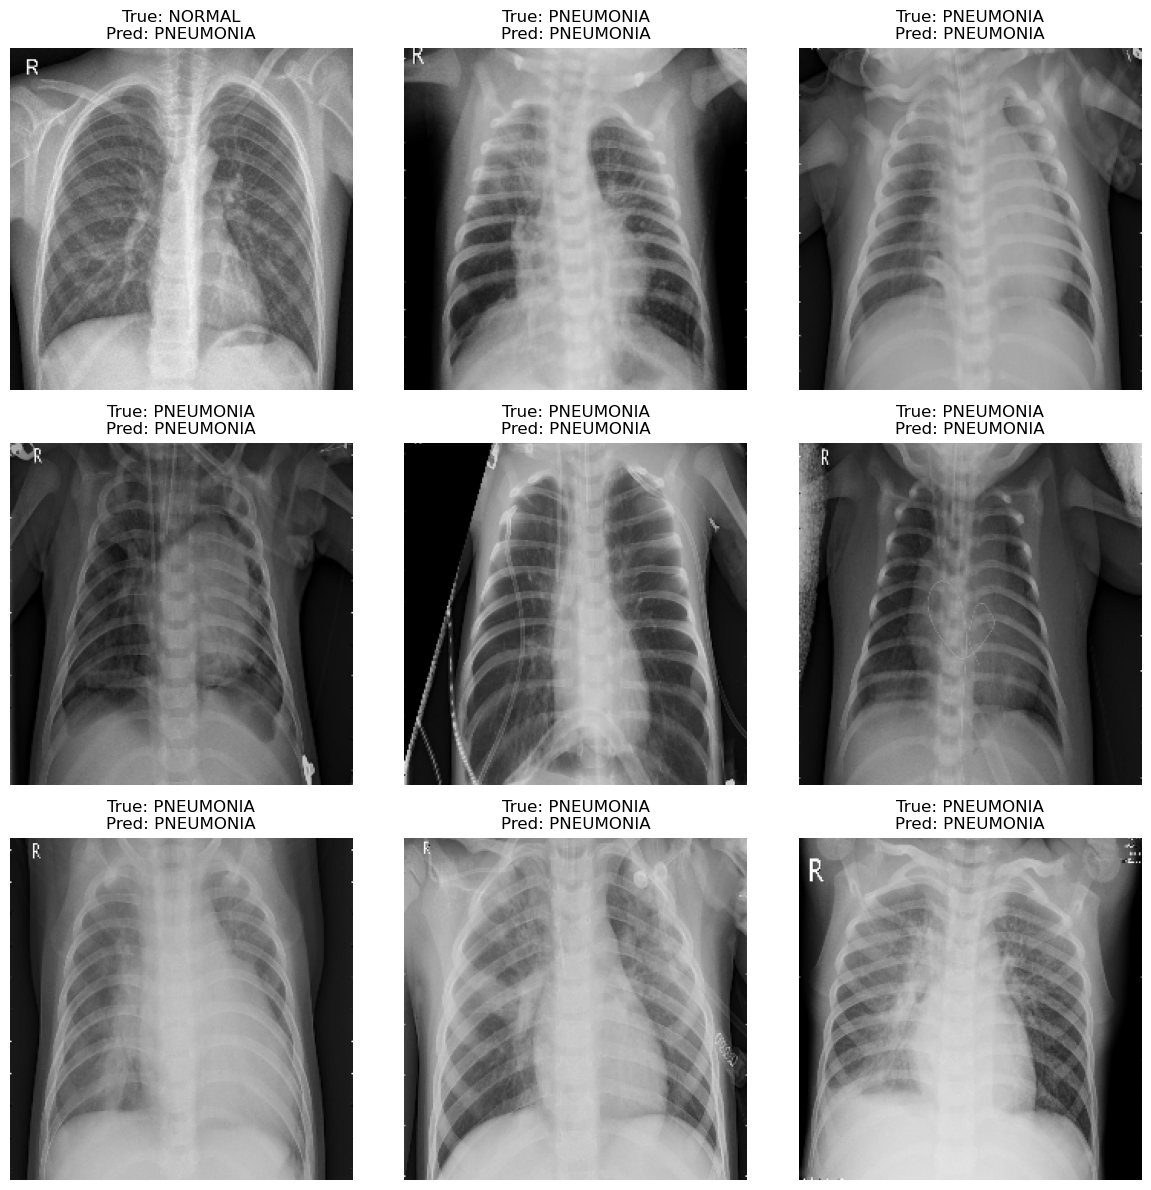

In [31]:
plt.figure(figsize=(12, 12))
for i, (image, label) in enumerate(test_ds.take(1)):  # Take 1 batch of test data
    predictions = model.predict(image)
    for j in range(9):  # Visualize 9 test images
        plt.subplot(3, 3, j + 1)
        plt.imshow(image[j].numpy())
        plt.title(f"True: {'NORMAL' if np.argmax(label[j]) == 0 else 'PNEUMONIA'}\n"
                  f"Pred: {'NORMAL' if np.argmax(predictions[j]) == 0 else 'PNEUMONIA'}")
        plt.axis("off")
plt.tight_layout()
plt.show()


In [33]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

In [39]:
model.save('pneumonia_detection_model.keras')